# x-ray 이미지

의료 영상 촬영은 인체를 세 방향의 단면으로 나누어 진행됩니다.
- Sagittal Plane: 시상면. 사람을 왼쪽과 오른쪽으로 나누는 면
- Coronal Plane: 관상면. 인체를 앞뒤로 나누는 면
- Transverse Plane: 횡단면(수평면). 인체를 상하로 나누는 면

이미지를 찍을때 우리가 정면을 바라보고 찍기 때문에, 이미지 상의 오른쪽은 사실 우리 몸의 왼쪽 부분에 해당됩니다.

### x-ray 특성

손을 찍은 사진을 본다고 가정했을때, 
- 뼈: 하얀색
- 근육 및 지방: 연한 회색
- 공기: 검은색

흉부 쪽의 영상을 본다고 가정했을때,
- 갈비뼈: 하얀색
- 폐: 검은색
- 어깨 쪽의 지방 및 근육: 연한 회색

# 폐렴을 진단해보자(1)

### 데이터셋: Chest X-Ray Images
- 3개의 폴더(train, test, val)로 구성되며, 각 이 이미지 카테고리 (폐렴/정상)에 대한 하위 폴더를 포함
- 5856개의 x-ray 이미지와 2개의 범주 (폐렴/정상)이 있고 데이터 크기는 종 1.2GB 가량
- 해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5세 소아 환자의 흉부 X선 영상
- 폐렴은 크게 두가지로 나뉘는데, 하나는 세균성 폐렴(bacterial pneumonia), 그리고 바이러스성 폐렴(viral pneumonia)로 나뉨. 두가지 폐렴의 패턴이 보이므로, 딥러닝에 이 패턴을 인식시킴

### set-up

In [1]:
# import
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# 필요한 변수 생성


# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


### 데이터 가져오기

In [3]:
# 데이터 개수 체크
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train:',len(train_filenames))
print('test:',len(test_filenames))
print('validation:',len(val_filenames))

train: 5216
test: 624
validation: 16


In [4]:
# validation 개수가 너무 적어 train에서 validation에 쓰일 데이터를 가져옴
# train과 validation에 있는 데이터를 모은다음 train:val을 8:2로 분할

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train:',len(train_filenames))
print('test:',len(test_filenames))
print('validation:',len(val_filenames))

train: 4185
test: 624
validation: 1047


In [5]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.

# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0614-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1346_bacteria_3430.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

In [7]:
# tf.data 인스턴스를 만들어 봅시다. 
# tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없습니다.
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 G적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.
for image, label in train_ds.take(1): # train_ds.take(1):하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy()) # 폐렴이면 양성(True), 노말이면 음성(False)

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# 위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.
밑에 있는 prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

- repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다. 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다. 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화
데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

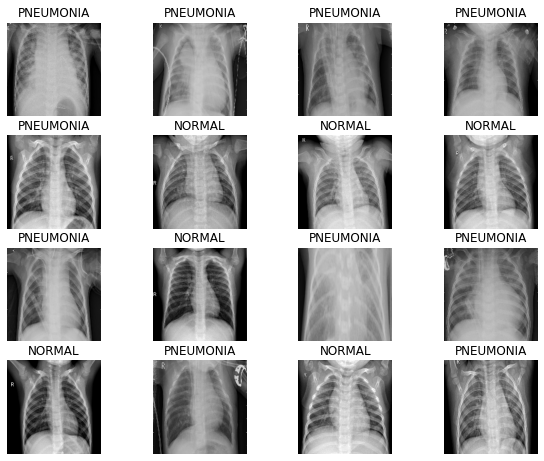

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 폐럼을 진단해보자(2)
### CNN 모델링
먼저, Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
# Dense Block은 아래와 같이 만듭니다.
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. 전형적인 CNN 모델과는 약간 다른 모델입니다.

어떤 부분이 가장 특이한가요? 눈에 띄셨을지 모르겠지만, 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다.

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.



In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### data imbalance

위에서 이야기된 데이터 imbalance문제 입니다. 한쪽 라벨이 너무 많은 경우를 imbalance하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 훈련
이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 145ms/step - loss: 0.5552 - accuracy: 0.7252 - precision: 0.9268 - recall: 0.6828 - val_loss: 0.6067 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 133ms/step - loss: 0.3003 - accuracy: 0.8766 - precision: 0.9647 - recall: 0.8659 - val_loss: 1.1550 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 35s 133ms/step - loss: 0.2269 - accuracy: 0.9054 - precision: 0.9815 - recall: 0.8927 - val_loss: 0.9401 - val_accuracy: 0.7346 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 35s 133ms/step - loss: 0.1948 - accuracy: 0.9207 - precision: 0.9810 - recall: 0.9119 - val_loss: 0.4296 - val_accuracy: 0.8288 - val_precision: 1.0000 - val_recall: 0.7673
Epoch 5/25
261/261 [==============================] - 35s 133ms/step - loss: 0.1715 - accura

# 결과 확인
그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

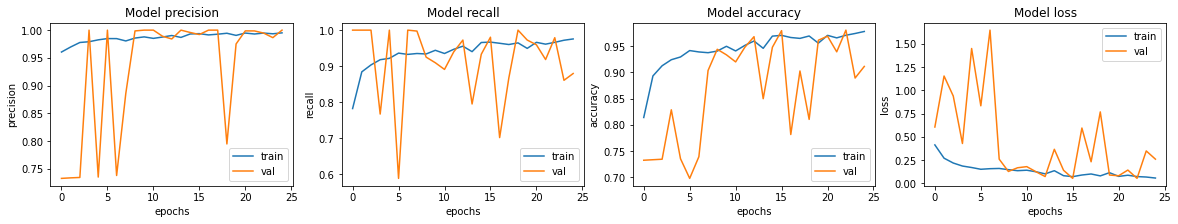

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.7886 - accuracy: 0.8446 - precision: 0.8322 - recall: 0.9410
Loss: 0.7885969877243042,
Accuracy: 0.8445512652397156,
Precision: 0.8321995735168457,
Recall: 0.9410256147384644


# 프로젝트: 폐렴 진단기 성능개선
- 하이퍼 파라미터 조정 -> BATCH_SIZE, EPOCHS
- 데이터 증강 -> 좌우 반전
- 모델의 변화 -> BatchNormalization, Dropout

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 64
EPOCHS = 35

print(ROOT_PATH)

/aiffel/aiffel


In [25]:
# 데이터 개수 체크
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train:',len(train_filenames))
print('test:',len(test_filenames))
print('validation:',len(val_filenames))

train: 5216
test: 624
validation: 16


In [31]:
# validation 개수가 너무 적어 train에서 validation에 쓰일 데이터를 가져옴
# train과 validation에 있는 데이터를 모은다음 train:val을 8:2로 분할

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train:',len(train_filenames))
print('test:',len(test_filenames))
print('validation:',len(val_filenames))

train: 4185
test: 624
validation: 1047


### data augmentaiton

In [50]:
# train, validation 초기화
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [51]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [52]:
image_batch, label_batch = next(iter(train_ds))

image_batch[0].shape

TensorShape([180, 180, 3])

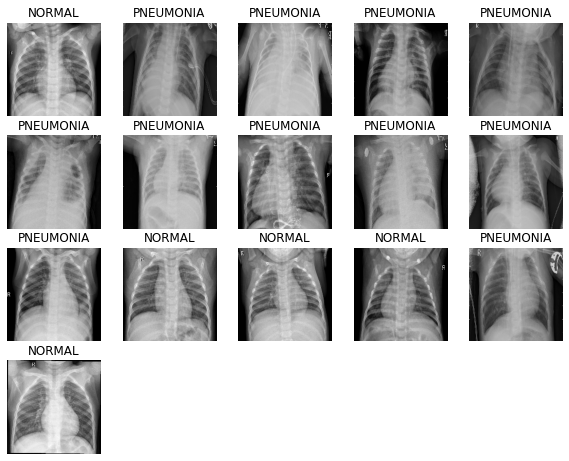

In [53]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        # print(image_batch[n])
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### Dropout 비율 변경

In [62]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [63]:
def build_model_dropout_change():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.4), # 기존 0.2 -> 변경 0.4
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [64]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model_dropout_change()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [65]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
65/65 [==============================] - 40s 502ms/step - loss: 0.8180 - accuracy: 0.5784 - precision: 0.8181 - recall: 0.5569 - val_loss: 0.6442 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/35
65/65 [==============================] - 32s 491ms/step - loss: 0.3323 - accuracy: 0.8432 - precision: 0.9734 - recall: 0.8117 - val_loss: 0.6057 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/35
65/65 [==============================] - 31s 484ms/step - loss: 0.2164 - accuracy: 0.9083 - precision: 0.9799 - recall: 0.8955 - val_loss: 0.7676 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/35
65/65 [==============================] - 31s 484ms/step - loss: 0.1881 - accuracy: 0.9323 - precision: 0.9799 - recall: 0.9295 - val_loss: 0.8717 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/35
65/65 [==============================] - 31s 485ms/step - loss: 0.1643 - accuracy: 0.9412

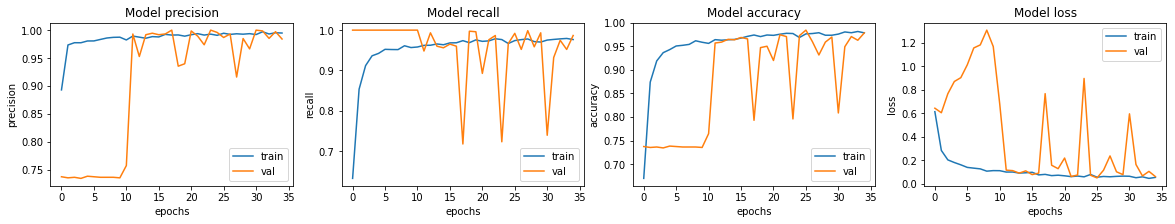

In [66]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [67]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 73ms/step - loss: 1.4556 - accuracy: 0.7244 - precision: 0.6960 - recall: 0.9923


### BatchNormalization삭제와 Dropout 비율 변경

In [55]:
# conv_block 재정의
def conv_block_bn_delete(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block


In [56]:
# dense_block 재정의
def dense_block_bn_delete(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [57]:
def build_model_batch_delete():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_bn_delete(32),
        conv_block_bn_delete(64),
        
        conv_block_bn_delete(128),
        tf.keras.layers.Dropout(0.4), # original: 0.2
        
        conv_block_bn_delete(256),
        tf.keras.layers.Dropout(0.4), # original: 0.2
        
        tf.keras.layers.Flatten(),
        dense_block_bn_delete(512, 0.5), 
        dense_block_bn_delete(128, 0.3), 
        dense_block_bn_delete(64, 0.1),  
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [58]:
with tf.device('/GPU:0'): # 이미지 훈련을 위해 GPU사용
    model = build_model_batch_delete()

    METRICS = [ # 성과 측정을 위해 metrics으로 'accuracy', 'precision', 'recall' 사용
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [59]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
65/65 [==============================] - 67s 505ms/step - loss: 0.5208 - accuracy: 0.7685 - precision: 0.8531 - recall: 0.8408 - val_loss: 0.5803 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/35
65/65 [==============================] - 32s 494ms/step - loss: 0.2054 - accuracy: 0.9181 - precision: 0.9761 - recall: 0.9115 - val_loss: 0.6421 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/35
65/65 [==============================] - 31s 483ms/step - loss: 0.1521 - accuracy: 0.9393 - precision: 0.9848 - recall: 0.9344 - val_loss: 0.5918 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/35
65/65 [==============================] - 31s 485ms/step - loss: 0.1340 - accuracy: 0.9394 - precision: 0.9860 - recall: 0.9327 - val_loss: 0.8548 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/35
65/65 [==============================] - 31s 484ms/step - loss: 0.1542 - accuracy: 0.9435

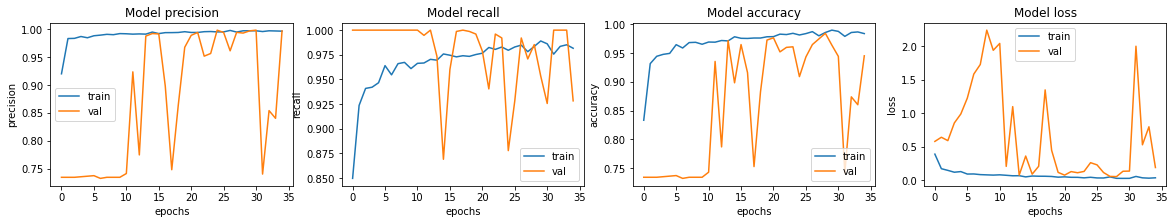

In [60]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [61]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 72ms/step - loss: 1.4090 - accuracy: 0.8077 - precision: 0.7824 - recall: 0.9590: 0s - loss: 1.4336 - accuracy: 0.8147 - precision: 0.7944 - recall


# 회고
https://github.com/Shinest-changwon/AIFFEL_Exploration/blob/master/E14_Diagnose_Pneumonia/%5BE14%5DDiagnose_Pneumonia.ipynb 의 코드를 참조해서 이번 프로젝트를 진행했습니다.

의료데이터를 접해볼 수 있다는 것에 일단 신기했고, 뭔가 미래에만 있을법한 일을 내가 하고 있다는 느낌이 들었습니다.
이번 노드를 통해서 데이터의 균형을 맞추는것과 데이터 증강을 하게 되었는데, 이 스킬들이 나중에 더 복잡하고 많은 데이터를 다루게 될 때 큰 도움이 될거 같습니다.

dropout의 비율을 더 높이고 학습을 진행했더니, 오히려 정확도가 떨어지는 것을 확인했습니다. 그리고 dropout의 비율을 변화시킨것과 batchnormalization을 사용안하고 학습을 진행했더니, 오히려 정확도가 올라간것을 확인했습니다. 정확도가 내려갈것이라고 예상을 했는데 전혀 다른 결과가 나와서 신기했습니다.